<a href="https://colab.research.google.com/github/soutrik71/pytorch_classics/blob/main/APTorch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will discuss series of experiment for classification task using LSTM
* Single layer LSTM
* Multi layer LSTM
* Stacked LSTM with different hidden layers
* Bidirectional LSTM
* Model Explainability using LIME

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=c110b80354013ac31df285a0493ebacd058fb91f07625bf82f59ce46c446ea04
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


#### Imports and Helpers

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader
from torchtext import data
from torchtext import datasets
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import re
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from torchsummary import summary
from torchview import draw_graph
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [13]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 1024
epochs = 10
lr = 1e-3

Random seed set as 42
cuda


In [6]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()


#### DataPrep- Same process as that of session-5

In [7]:
# get train and testset
train_dataset, test_dataset  = datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [8]:
# we wil use advanced tokenizer provided by torch
tokenizer = get_tokenizer("basic_english")
print(tokenizer("You can now install TorchText using pip!"))

['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']


In [9]:
def build_vocab_iter(datasets):
  """yields tokenized text """
  for dataset in datasets:
    for _, text in dataset:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab_iter([train_dataset, test_dataset]), specials=["<unk>"]) # build vocab from an iterator
vocab.set_default_index(vocab["<unk>"]) # anything unk will be have a default index

##### Dataloader

In [17]:
max_words = 50

In [18]:
def vectorize_batch(batch):
  """Vectorize the batch and used in dataloader"""
  Y,X  = list(zip(*batch))
  X=[vocab(tokenizer(sample)) for sample in X]

  X = [sample+([0]* (max_words-len(sample))) if len(sample) < max_words else sample[:max_words] for sample in X] ## Bringing all samples to 50 length ie standardization of length

  Y = [0 if y==0 else y-1 for y in Y] # converting label starting form 0

  return torch.tensor(X, dtype=torch.int64).to(device), torch.tensor(Y, dtype=torch.int64).to(device)

In [19]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, collate_fn=vectorize_batch)

In [20]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 50]) torch.Size([1024])


#### Basic LSTM Network

The Embedding Layer processes input indexes from the vectorization function, initialized with embedding length 50 and vocabulary length, creating a weight tensor of shape (vocab_len, embed_len) with an embedding vector of length 50 for each token. It maps token indexes to float vectors based on the index value, transforming tensors from (batch_size, max_tokens) to (batch_size, max_tokens, embed_len). The LSTM Layer receives embeddings from the embedding layer, initialized with one LSTM layer, output shape of 75, and input shape matching the embedding length. It iterates through embeddings of each text example, producing hidden and output tensors. Using the hidden state and carry as input (usually random numbers for the first token), subsequent tokens generate their own hidden and carry tensors. Input to the LSTM is (batch_size, max_tokens, embed_len), output is (batch_size, max_tokens, hidden_dim). The Linear layer, with 4 output units (matching target classes), takes the last LSTM input to predict the network's output. Notably, it uses the last output of each example generated by the LSTM, capturing the context of the entire example.

In [25]:
embedding_dim = 50
hidden_dim = 75
output_dim = 4
n_layers = 1

In [42]:
class LSTMBaselineClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(LSTMBaselineClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim, num_layers = n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1)

    def init_weights(self , X_batch):
      hidden , carry = torch.randn(self.n_layers, X_batch.size(0), self.hidden_dim), torch.randn(self.n_layers, X_batch.size(0), self.hidden_dim)
      return hidden.to(device), carry.to(device)


    def forward(self, X_batch):
      embeddings = self.embedding(X_batch)
      x = self.dropout(embeddings)
      hidden, carry = self.init_weights(X_batch)
      out, (hidden, carry) = self.lstm(x, (hidden, carry))
      out = self.fc(out[:, -1, :])
      return out



In [43]:
lstm_baseline = LSTMBaselineClassifier(embedding_dim, hidden_dim, output_dim, n_layers)
lstm_baseline.to(device)

LSTMBaselineClassifier(
  (embedding): Embedding(98635, 50)
  (lstm): LSTM(50, 75, batch_first=True)
  (fc): Linear(in_features=75, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [44]:
for layer in lstm_baseline.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(98635, 50)
Parameters : 
torch.Size([98635, 50])

Layer : LSTM(50, 75, batch_first=True)
Parameters : 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer : Linear(in_features=75, out_features=4, bias=True)
Parameters : 
torch.Size([4, 75])
torch.Size([4])

Layer : Dropout(p=0.1, inplace=False)
Parameters : 



In [45]:
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=-1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [46]:
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=-1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [47]:
# driver setup
optimizer = optim.Adam(lstm_baseline.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [48]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(lstm_baseline, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(lstm_baseline, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.3338008502782401 Avg Train Metric: 0.27972306677345504: 100%|██████████| 118/118 [00:08<00:00, 13.17it/s]
Avg Test Loss: 1.1542580425739288 Avg Test Metric: 0.45496996492147446: 100%|██████████| 8/8 [00:00<00:00, 24.15it/s]


Epoch 1


Avg Train Loss: 0.9776259145494235 Avg Train Metric: 0.5021806245638152: 100%|██████████| 118/118 [00:07<00:00, 15.59it/s]
Avg Test Loss: 0.8620762899518013 Avg Test Metric: 0.6501815393567085: 100%|██████████| 8/8 [00:00<00:00, 23.42it/s]


Epoch 2


Avg Train Loss: 0.6799988357697503 Avg Train Metric: 0.7045731443469807: 100%|██████████| 118/118 [00:08<00:00, 14.55it/s]
Avg Test Loss: 0.5818757563829422 Avg Test Metric: 0.7888005077838898: 100%|██████████| 8/8 [00:00<00:00, 22.98it/s]


Epoch 3


Avg Train Loss: 0.48910039511777587 Avg Train Metric: 0.8155288246728606: 100%|██████████| 118/118 [00:08<00:00, 14.48it/s]
Avg Test Loss: 0.4635227844119072 Avg Test Metric: 0.8345127627253532: 100%|██████████| 8/8 [00:00<00:00, 23.69it/s]


Epoch 4


Avg Train Loss: 0.40912180229768913 Avg Train Metric: 0.8527649641036987: 100%|██████████| 118/118 [00:07<00:00, 15.32it/s]
Avg Test Loss: 0.41489438712596893 Avg Test Metric: 0.8486211448907852: 100%|██████████| 8/8 [00:00<00:00, 23.83it/s]


Epoch 5


Avg Train Loss: 0.3628579206385855 Avg Train Metric: 0.8728443076044826: 100%|██████████| 118/118 [00:08<00:00, 14.64it/s]
Avg Test Loss: 0.39772960916161537 Avg Test Metric: 0.8580247536301613: 100%|██████████| 8/8 [00:00<00:00, 24.11it/s]


Epoch 6


Avg Train Loss: 0.32829084638821876 Avg Train Metric: 0.8866197876000809: 100%|██████████| 118/118 [00:08<00:00, 14.58it/s]
Avg Test Loss: 0.37869423627853394 Avg Test Metric: 0.8641699254512787: 100%|██████████| 8/8 [00:00<00:00, 24.69it/s]


Epoch 7


Avg Train Loss: 0.3003231121574418 Avg Train Metric: 0.8986865994283708: 100%|██████████| 118/118 [00:07<00:00, 15.63it/s]
Avg Test Loss: 0.35908984392881393 Avg Test Metric: 0.8724197372794151: 100%|██████████| 8/8 [00:00<00:00, 15.02it/s]


Epoch 8


Avg Train Loss: 0.2808749408034955 Avg Train Metric: 0.9054827578997208: 100%|██████████| 118/118 [00:07<00:00, 14.87it/s]
Avg Test Loss: 0.33187925070524216 Avg Test Metric: 0.8839633911848068: 100%|██████████| 8/8 [00:00<00:00, 24.38it/s]


Epoch 9


Avg Train Loss: 0.25973322280382705 Avg Train Metric: 0.9133211672306061: 100%|██████████| 118/118 [00:07<00:00, 14.78it/s]
Avg Test Loss: 0.3252891041338444 Avg Test Metric: 0.8807770758867264: 100%|██████████| 8/8 [00:00<00:00, 24.01it/s]


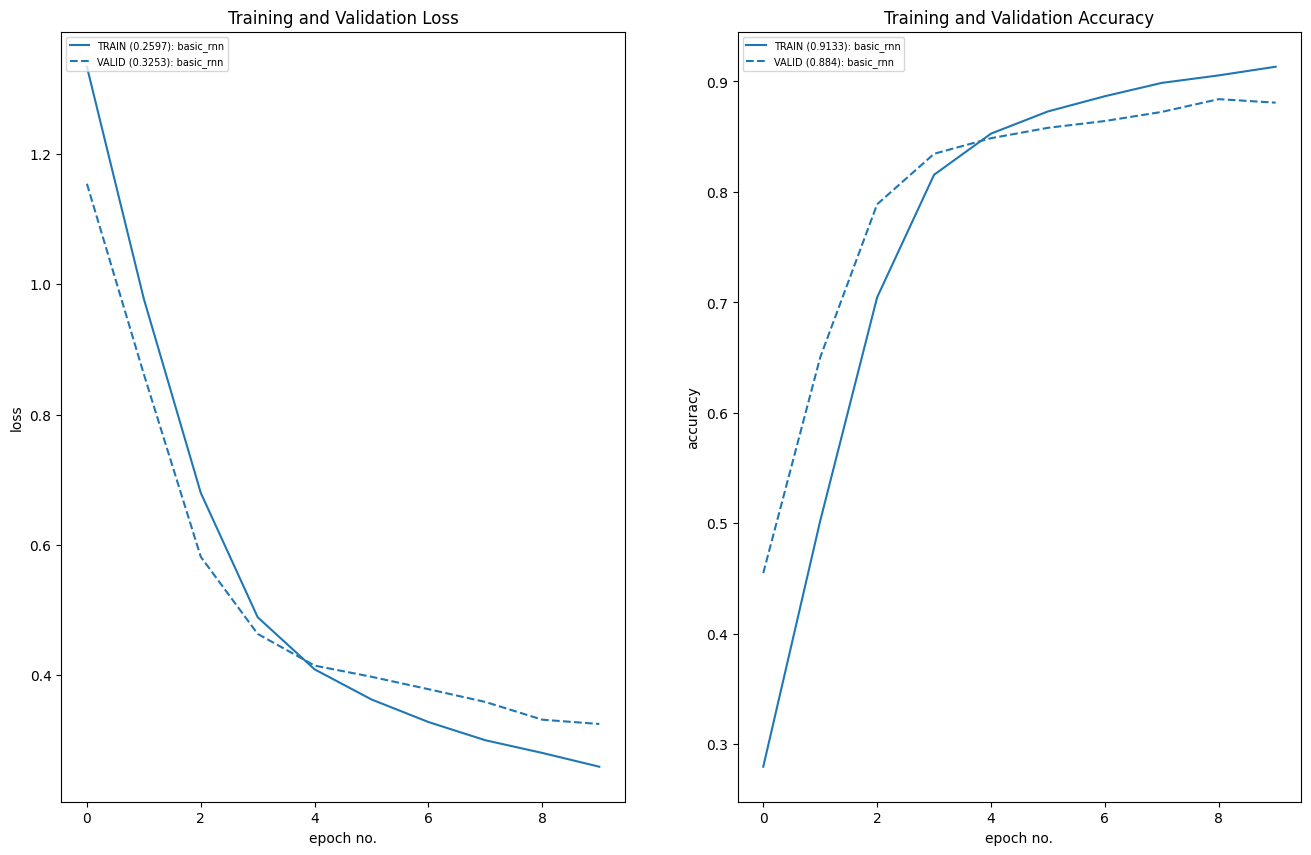

In [49]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['basic_lstm'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [50]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

In [51]:
# predictions
Y_actual, Y_preds = MakePredictions(lstm_baseline, test_loader)

In [52]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8913157894736842

Classification Report : 
              precision    recall  f1-score   support

       World       0.88      0.91      0.89      1900
      Sports       0.95      0.96      0.95      1900
    Business       0.86      0.85      0.85      1900
    Sci/Tech       0.87      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600


Confusion Matrix : 
[[1720   58   77   45]
 [  43 1823    8   26]
 [ 109   15 1606  170]
 [  82   26  167 1625]]


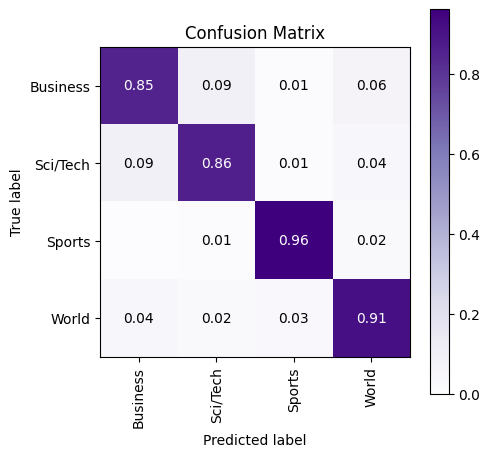

In [53]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Multiple LSTM layers
Application on 3 stacked LSTM layers with 128 hidden units each

In [58]:
n_layers = 3
hidden_dim = 128

In [59]:
class LSTMExpandedClassifer(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
    super(LSTMExpandedClassifer, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.dropout = nn.Dropout(0.1)


  def init_weights(self , X_batch):
      hidden , carry = torch.randn(self.n_layers, X_batch.size(0), self.hidden_dim), torch.randn(self.n_layers, X_batch.size(0), self.hidden_dim)
      return hidden.to(device), carry.to(device)

  def forward(self, X_batch):
    x = self.embedding(X_batch)
    x = self.dropout(x)
    hidden, carry = self.init_weights(X_batch)
    out, (hidden, carry) = self.lstm(x, (hidden, carry))
    out = self.fc(out[:, -1, :])
    return out

In [60]:
stacked_lstm_model = LSTMExpandedClassifer(embedding_dim, hidden_dim, output_dim, n_layers)
stacked_lstm_model.to(device)

LSTMExpandedClassifer(
  (embedding): Embedding(98635, 50)
  (lstm): LSTM(50, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [61]:
# driver setup
optimizer = optim.Adam(stacked_lstm_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [62]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(stacked_lstm_model, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(stacked_lstm_model, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.2184206030126346 Avg Train Metric: 0.32452024569955923: 100%|██████████| 118/118 [00:13<00:00,  8.55it/s]
Avg Test Loss: 1.0179424285888672 Avg Test Metric: 0.5336368232965469: 100%|██████████| 8/8 [00:00<00:00, 15.48it/s]


Epoch 1


Avg Train Loss: 0.831015641406431 Avg Train Metric: 0.5877272330098233: 100%|██████████| 118/118 [00:16<00:00,  7.13it/s]
Avg Test Loss: 0.6516879349946976 Avg Test Metric: 0.7522135972976685: 100%|██████████| 8/8 [00:00<00:00,  9.73it/s]


Epoch 2


Avg Train Loss: 0.542003366149078 Avg Train Metric: 0.7784637788594779: 100%|██████████| 118/118 [00:16<00:00,  7.16it/s]
Avg Test Loss: 0.4744814597070217 Avg Test Metric: 0.8275083377957344: 100%|██████████| 8/8 [00:00<00:00, 15.39it/s]


Epoch 3


Avg Train Loss: 0.4190829295223042 Avg Train Metric: 0.8456576229152033: 100%|██████████| 118/118 [00:13<00:00,  9.02it/s]
Avg Test Loss: 0.3988926112651825 Avg Test Metric: 0.8557496070861816: 100%|██████████| 8/8 [00:00<00:00,  9.33it/s]


Epoch 4


Avg Train Loss: 0.35516299964007686 Avg Train Metric: 0.8739068452584542: 100%|██████████| 118/118 [00:18<00:00,  6.31it/s]
Avg Test Loss: 0.3718975968658924 Avg Test Metric: 0.8694696947932243: 100%|██████████| 8/8 [00:00<00:00, 15.45it/s]


Epoch 5


Avg Train Loss: 0.3160095488873579 Avg Train Metric: 0.8884408468917265: 100%|██████████| 118/118 [00:13<00:00,  8.99it/s]
Avg Test Loss: 0.35571717843413353 Avg Test Metric: 0.8754596710205078: 100%|██████████| 8/8 [00:00<00:00, 15.31it/s]


Epoch 6


Avg Train Loss: 0.29123777428926045 Avg Train Metric: 0.8977918059138928: 100%|██████████| 118/118 [00:13<00:00,  8.89it/s]
Avg Test Loss: 0.3510812148451805 Avg Test Metric: 0.8707583025097847: 100%|██████████| 8/8 [00:00<00:00, 15.40it/s]


Epoch 7


Avg Train Loss: 0.2653005623211295 Avg Train Metric: 0.9080232841483618: 100%|██████████| 118/118 [00:13<00:00,  8.75it/s]
Avg Test Loss: 0.33654047548770905 Avg Test Metric: 0.8833750784397125: 100%|██████████| 8/8 [00:00<00:00, 14.80it/s]


Epoch 8


Avg Train Loss: 0.24644966183577555 Avg Train Metric: 0.9147079006090002: 100%|██████████| 118/118 [00:13<00:00,  8.98it/s]
Avg Test Loss: 0.2966460511088371 Avg Test Metric: 0.8973565772175789: 100%|██████████| 8/8 [00:00<00:00, 14.71it/s]


Epoch 9


Avg Train Loss: 0.23049118546611172 Avg Train Metric: 0.9208025755518574: 100%|██████████| 118/118 [00:13<00:00,  8.97it/s]
Avg Test Loss: 0.31270619109272957 Avg Test Metric: 0.8880760371685028: 100%|██████████| 8/8 [00:00<00:00, 10.76it/s]


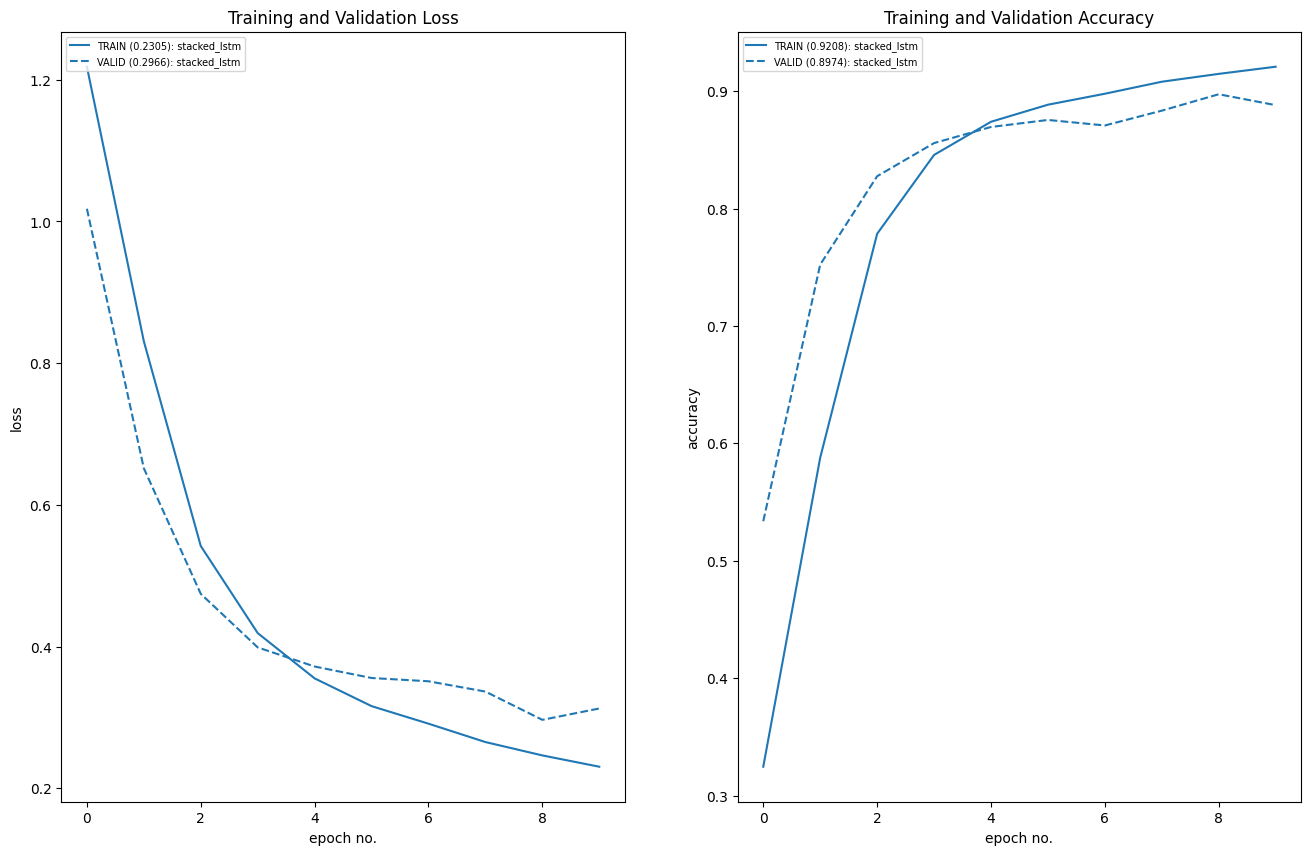

In [63]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['stacked_lstm'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [64]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).cpu().detach().numpy()

In [65]:
# predictions
Y_actual, Y_preds = MakePredictions(stacked_lstm_model, test_loader)

In [66]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8925

Classification Report : 
              precision    recall  f1-score   support

       World       0.93      0.87      0.90      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.81      0.91      0.85      1900
    Sci/Tech       0.90      0.81      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.90      0.89      0.89      7600
weighted avg       0.90      0.89      0.89      7600


Confusion Matrix : 
[[1660   58  123   59]
 [  19 1852   18   11]
 [  45   18 1727  110]
 [  58   25  273 1544]]


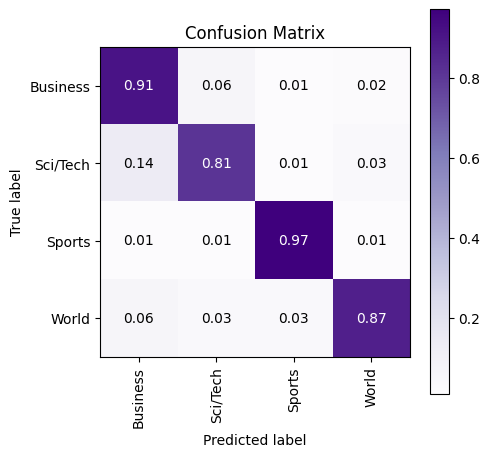

In [67]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Multi Stack LSTM
Three LSTM layers are utilized with hidden sizes of 55, 65, and 75 respectively. The output of the embedding layer feeds into the first LSTM, which then passes its output to the second LSTM, and so on until the last LSTM layer. Each LSTM layer maintains separate hidden and carry states. Finally, the output of the last LSTM layer is directed to the Linear layer for prediction.

In [74]:
hidden_layers = [55, 65, 75]
n_layers = 1

In [75]:
class MultiStackLSTMClassifer(nn.Module):
  def __init__(self, embedding_dim, hidden_layers, output_dim, n_layers):
    super(MultiStackLSTMClassifer, self).__init__()

    self.hidden_layers = hidden_layers
    self.n_layers = n_layers

    self.embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embedding_dim)
    self.lstm1 = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_layers[0], num_layers = n_layers, batch_first = True)
    self.lstm2 = nn.LSTM(input_size = hidden_layers[0], hidden_size = hidden_layers[1], num_layers = n_layers, batch_first = True)
    self.lstm3 = nn.LSTM(input_size = hidden_layers[1], hidden_size = hidden_layers[2], num_layers = n_layers, batch_first = True)
    self.fc = nn.Linear(hidden_layers[2], output_dim)
    self.dropout = nn.Dropout(0.1)

  def init_weights(self, X_batch, hidden_size):
    hidden = torch.randn(self.n_layers, X_batch.size(0), hidden_size)
    carry = torch.randn(self.n_layers, X_batch.size(0), hidden_size)

    return hidden.to(device), carry.to(device)

  def forward(self, X_batch):
    x = self.embedding(X_batch)
    x = self.dropout(x)

    hidden, carry = self.init_weights(X_batch, self.hidden_layers[0])
    out, (hidden, carry) = self.lstm1(x, (hidden, carry))

    hidden, carry = self.init_weights(out, self.hidden_layers[1])
    out, (hidden, carry) = self.lstm2(out, (hidden, carry))

    hidden, carry = self.init_weights(out, self.hidden_layers[2])
    out, (hidden, carry) = self.lstm3(out, (hidden, carry))

    out = self.fc(out[:, -1, :])

    return out



In [76]:
multi_stack_lstm_model = MultiStackLSTMClassifer(embedding_dim, hidden_layers, output_dim, n_layers)
multi_stack_lstm_model.to(device)

MultiStackLSTMClassifer(
  (embedding): Embedding(98635, 50)
  (lstm1): LSTM(50, 55, batch_first=True)
  (lstm2): LSTM(55, 65, batch_first=True)
  (lstm3): LSTM(65, 75, batch_first=True)
  (fc): Linear(in_features=75, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [77]:
# driver setup
optimizer = optim.Adam(multi_stack_lstm_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [78]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(multi_stack_lstm_model, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(multi_stack_lstm_model, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.2567720064672374 Avg Train Metric: 0.3062318083593401: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s]
Avg Test Loss: 0.9932513907551765 Avg Test Metric: 0.5684416219592094: 100%|██████████| 8/8 [00:00<00:00, 19.56it/s]


Epoch 1


Avg Train Loss: 0.7808891989416995 Avg Train Metric: 0.627866002462678: 100%|██████████| 118/118 [00:09<00:00, 12.23it/s]
Avg Test Loss: 0.6188603788614273 Avg Test Metric: 0.7670363560318947: 100%|██████████| 8/8 [00:00<00:00, 21.32it/s]


Epoch 2


Avg Train Loss: 0.5356926789223138 Avg Train Metric: 0.7873902063248521: 100%|██████████| 118/118 [00:09<00:00, 12.44it/s]
Avg Test Loss: 0.4682319834828377 Avg Test Metric: 0.8299108371138573: 100%|██████████| 8/8 [00:00<00:00, 20.98it/s]


Epoch 3


Avg Train Loss: 0.43056095555677254 Avg Train Metric: 0.8379081053248907: 100%|██████████| 118/118 [00:09<00:00, 12.48it/s]
Avg Test Loss: 0.3999611884355545 Avg Test Metric: 0.8521967232227325: 100%|██████████| 8/8 [00:00<00:00, 19.70it/s]


Epoch 4


Avg Train Loss: 0.3699415912062435 Avg Train Metric: 0.8685419478658902: 100%|██████████| 118/118 [00:09<00:00, 13.08it/s]
Avg Test Loss: 0.35537416487932205 Avg Test Metric: 0.8688156455755234: 100%|██████████| 8/8 [00:00<00:00, 15.74it/s]


Epoch 5


Avg Train Loss: 0.3309935674828998 Avg Train Metric: 0.8849996606172141: 100%|██████████| 118/118 [00:09<00:00, 12.51it/s]
Avg Test Loss: 0.34517254307866096 Avg Test Metric: 0.8718590438365936: 100%|██████████| 8/8 [00:00<00:00, 21.54it/s]


Epoch 6


Avg Train Loss: 0.3007533790196403 Avg Train Metric: 0.8975345098366172: 100%|██████████| 118/118 [00:09<00:00, 12.59it/s]
Avg Test Loss: 0.32073426619172096 Avg Test Metric: 0.8875171393156052: 100%|██████████| 8/8 [00:00<00:00, 21.06it/s]


Epoch 7


Avg Train Loss: 0.27753039739899715 Avg Train Metric: 0.9045477267039024: 100%|██████████| 118/118 [00:09<00:00, 12.14it/s]
Avg Test Loss: 0.30937764048576355 Avg Test Metric: 0.891753226518631: 100%|██████████| 8/8 [00:00<00:00, 21.35it/s]


Epoch 8


Avg Train Loss: 0.2610732904177601 Avg Train Metric: 0.9111522082555092: 100%|██████████| 118/118 [00:09<00:00, 12.47it/s]
Avg Test Loss: 0.30701759085059166 Avg Test Metric: 0.8928530961275101: 100%|██████████| 8/8 [00:00<00:00, 20.92it/s]


Epoch 9


Avg Train Loss: 0.24459393840220015 Avg Train Metric: 0.9171685525926493: 100%|██████████| 118/118 [00:08<00:00, 13.17it/s]
Avg Test Loss: 0.2911288496106863 Avg Test Metric: 0.8952513784170151: 100%|██████████| 8/8 [00:00<00:00, 13.13it/s]


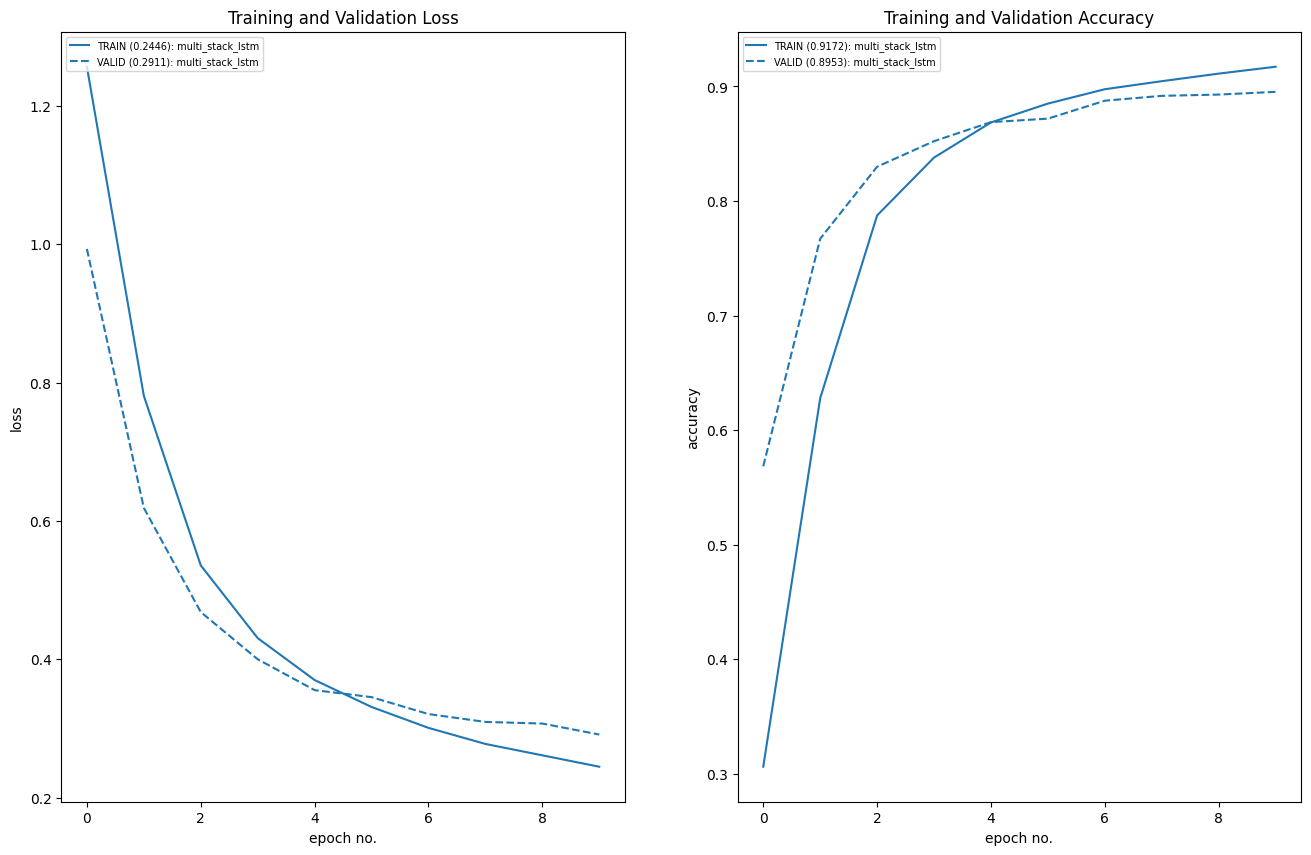

In [79]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['multi_stack_lstm'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [80]:
# predictions
Y_actual, Y_preds = MakePredictions(multi_stack_lstm_model, test_loader)

In [84]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.8990789473684211

Classification Report : 
              precision    recall  f1-score   support

       World       0.92      0.89      0.91      1900
      Sports       0.96      0.96      0.96      1900
    Business       0.84      0.89      0.86      1900
    Sci/Tech       0.88      0.85      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600


Confusion Matrix : 
[[1695   49  111   45]
 [  32 1820   26   22]
 [  48    9 1698  145]
 [  63   22  195 1620]]


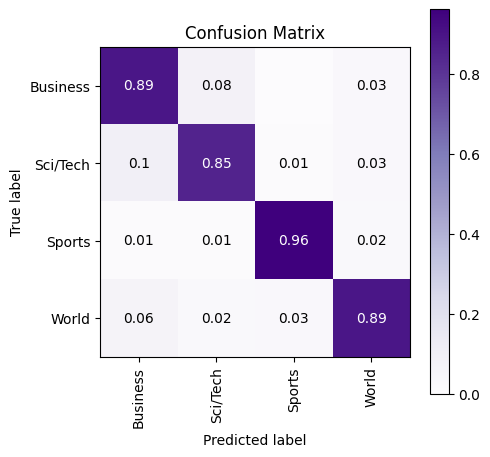

In [83]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Bidirectional LSTM
ncorporating a bidirectional LSTM layer involves setting the bidirectional parameter to True in the LSTM() constructor. The network architecture remains similar to the third approach, with adjustments made for bidirectional processing. Specifically, the input units of the Linear layer are doubled to accommodate the combined outputs generated in both forward and backward directions by the bidirectional LSTM layer.

In [86]:
n_layers = 3
hidden_layers = 128

In [87]:
class BidirectionalLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
    super(BidirectionalLSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, bidirectional = True)
    self.fc = nn.Linear(2 * hidden_dim, output_dim)
    self.dropout = nn.Dropout(0.1)


  def init_weights(self , X_batch):
      hidden , carry = torch.randn(2 * self.n_layers, X_batch.size(0), self.hidden_dim), torch.randn(2 * self.n_layers, X_batch.size(0), self.hidden_dim)
      return hidden.to(device), carry.to(device)

  def forward(self, X_batch):
    x = self.embedding(X_batch)
    x = self.dropout(x)

    hidden, carry = self.init_weights(X_batch)

    out, (hidden, carry) = self.lstm(x, (hidden, carry))
    out = self.fc(out[:, -1, :])
    return out

In [88]:
bidirect_lstm = BidirectionalLSTM(embedding_dim, hidden_layers, output_dim, n_layers).to(device)
bidirect_lstm

BidirectionalLSTM(
  (embedding): Embedding(98635, 50)
  (lstm): LSTM(50, 128, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [89]:
# driver setup
optimizer = optim.Adam(bidirect_lstm.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=4)

In [90]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(bidirect_lstm, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(bidirect_lstm, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.1853351683939917 Avg Train Metric: 0.33070323174282656: 100%|██████████| 118/118 [00:28<00:00,  4.15it/s]
Avg Test Loss: 0.8470680341124535 Avg Test Metric: 0.6606025397777557: 100%|██████████| 8/8 [00:00<00:00, 10.18it/s]


Epoch 1


Avg Train Loss: 0.6611535352165416 Avg Train Metric: 0.7087564357256485: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]
Avg Test Loss: 0.5101393051445484 Avg Test Metric: 0.8128078356385231: 100%|██████████| 8/8 [00:00<00:00, 10.20it/s]


Epoch 2


Avg Train Loss: 0.4623066368749586 Avg Train Metric: 0.8227921133324251: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]
Avg Test Loss: 0.4569149501621723 Avg Test Metric: 0.8286435902118683: 100%|██████████| 8/8 [00:00<00:00, 10.26it/s]


Epoch 3


Avg Train Loss: 0.38272498194443977 Avg Train Metric: 0.8572688239105677: 100%|██████████| 118/118 [00:24<00:00,  4.76it/s]
Avg Test Loss: 0.3695080392062664 Avg Test Metric: 0.8608858957886696: 100%|██████████| 8/8 [00:00<00:00, 10.36it/s]


Epoch 4


Avg Train Loss: 0.33172476392681316 Avg Train Metric: 0.8809196938902645: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]
Avg Test Loss: 0.3231370560824871 Avg Test Metric: 0.8764057233929634: 100%|██████████| 8/8 [00:00<00:00, 10.39it/s]


Epoch 5


Avg Train Loss: 0.29388978117603365 Avg Train Metric: 0.8948793290025097: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]
Avg Test Loss: 0.32298044860363007 Avg Test Metric: 0.8717841878533363: 100%|██████████| 8/8 [00:00<00:00, 10.32it/s]


Epoch 6


Avg Train Loss: 0.26854816988363106 Avg Train Metric: 0.9049474187826706: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]
Avg Test Loss: 0.2959727421402931 Avg Test Metric: 0.8928636536002159: 100%|██████████| 8/8 [00:00<00:00, 10.36it/s]


Epoch 7


Avg Train Loss: 0.24750145966723813 Avg Train Metric: 0.9120049628160768: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]
Avg Test Loss: 0.2815334890037775 Avg Test Metric: 0.8992128744721413: 100%|██████████| 8/8 [00:00<00:00, 10.42it/s]


Epoch 8


Avg Train Loss: 0.22349403394480882 Avg Train Metric: 0.9226062105873883: 100%|██████████| 118/118 [00:24<00:00,  4.75it/s]
Avg Test Loss: 0.2757067531347275 Avg Test Metric: 0.9037156999111176: 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]


Epoch 9


Avg Train Loss: 0.20972279623403386 Avg Train Metric: 0.928218111648398: 100%|██████████| 118/118 [00:24<00:00,  4.91it/s]
Avg Test Loss: 0.2738264184445143 Avg Test Metric: 0.9036907106637955: 100%|██████████| 8/8 [00:01<00:00,  7.66it/s]


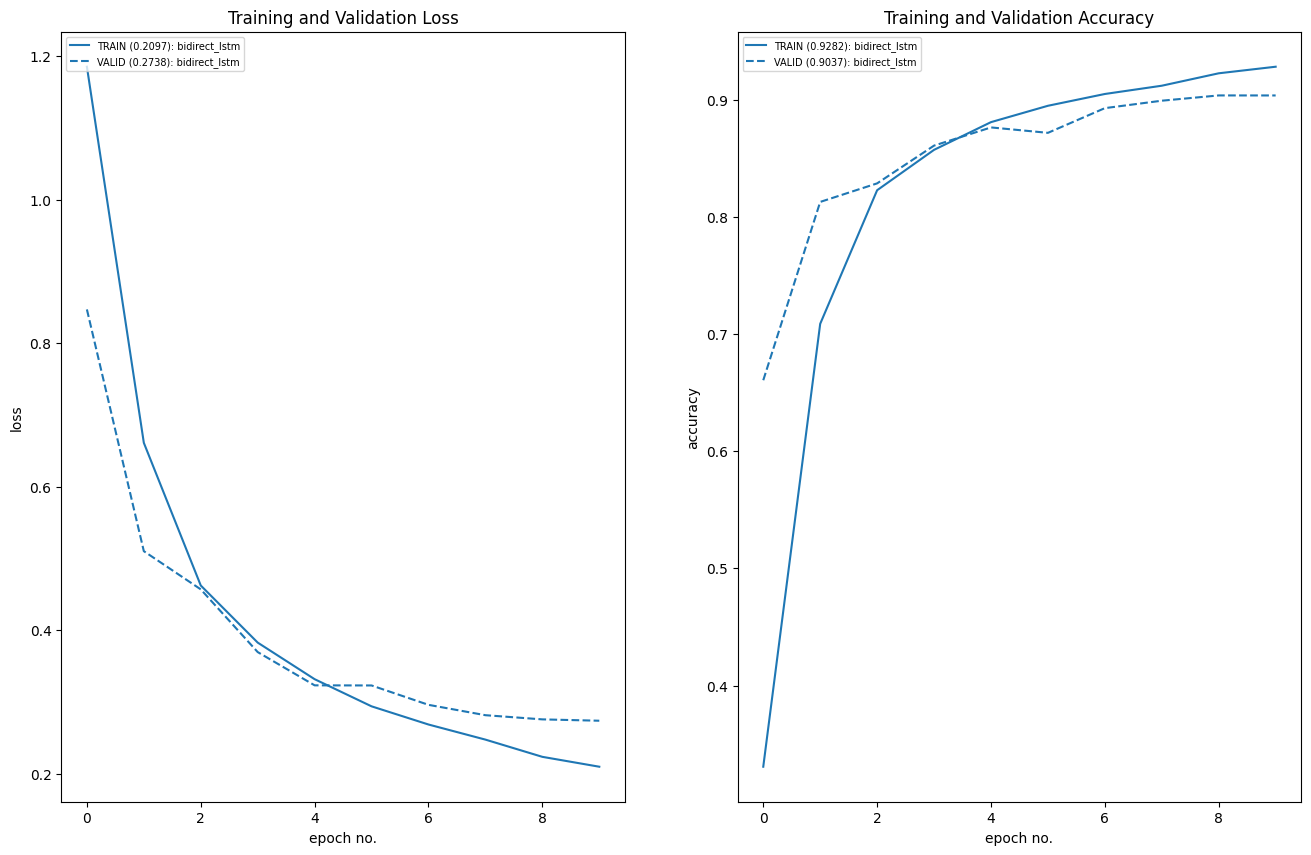

In [91]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['bidirect_lstm'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [95]:
# predictions
Y_actual, Y_preds = MakePredictions(bidirect_lstm, test_loader)

In [96]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9048684210526315

Classification Report : 
              precision    recall  f1-score   support

       World       0.94      0.89      0.91      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.88      0.87      0.87      1900
    Sci/Tech       0.86      0.89      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.91      0.90      0.90      7600
weighted avg       0.91      0.90      0.90      7600


Confusion Matrix : 
[[1686   61   73   80]
 [  14 1852   18   16]
 [  51   16 1652  181]
 [  43   26  144 1687]]


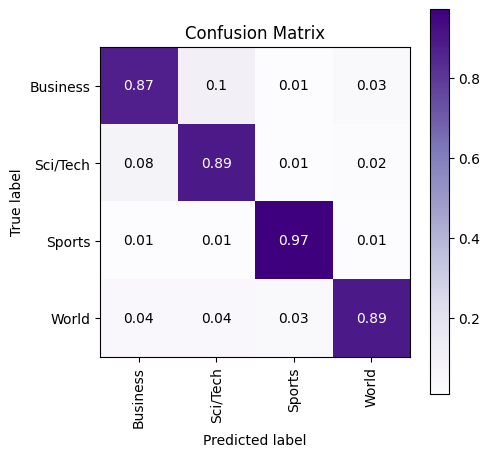

In [97]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

#### Model EXP

In [99]:
max_words = 50

In [100]:
X_test_text, Y_test = [], []
for Y, X in test_dataset:
    X_test_text.append(X)
    Y_test.append(Y-1)

len(X_test_text)

7600

In [102]:
from lime import lime_text
import numpy as np

explainer = lime_text.LimeTextExplainer(class_names=target_classes, verbose=True, random_state=42)

def make_predictions(X_batch_text):
    X = [vocab(tokenizer(text)) for text in X_batch_text]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] ## Bringing all samples to max_words length.
    logits = bidirect_lstm(torch.tensor(X, dtype=torch.int32).to(device))
    preds = F.softmax(logits, dim=-1)
    return preds.cpu().detach().numpy()

In [103]:
rng = np.random.RandomState()
idx = rng.randint(1, len(X_test_text))
print(X_test_text[idx])
print(Y_test[idx])

Gates and Ballmer get pay raises Bill Gates and Steve Ballmer each received total compensation of \$901,667 in Microsoft Corp.'s 2004 fiscal year, up 4.4 percent from \$863,447 one year ago.
3


In [104]:
explanation = explainer.explain_instance(X_test_text[idx], classifier_fn=make_predictions,
                                         labels=Y_test[idx:idx+1])
explanation.show_in_notebook()

Intercept 0.9055197009944929
Prediction_local [0.66380122]
Right: 0.7053272


References:

https://coderzcolumn.com/tutorials/artificial-intelligence/pytorch-lstm-for-text-classification-tasks

https://github.com/gabrielloye/LSTM_Sentiment-Analysis/blob/master/main.ipynb
